### Imports

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
np.random.seed(42)

# from scipy.special import softmax

### Neural model -- persistent activity

Adjusted Sequence: ['B3', 'A', 'D', 'C', 'D']


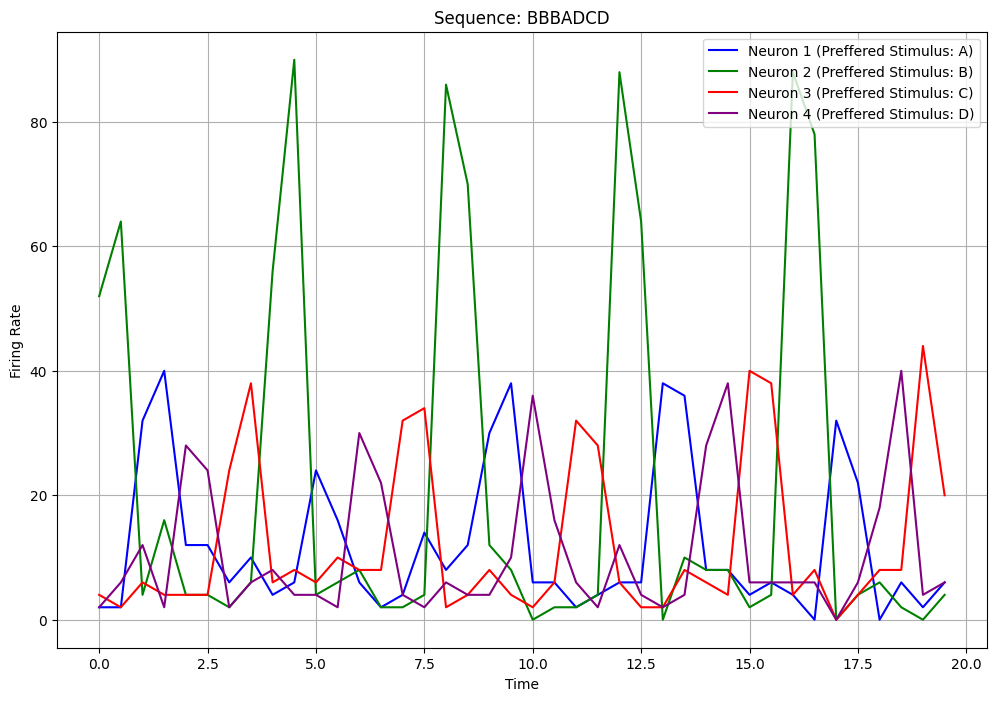

In [ ]:
# Temporal model

import numpy as np
import matplotlib.pyplot as plt

# Simulation settings
total_time = 20  # total time in seconds
dt = .05  # finer time step for Poisson generation
time = np.arange(0, total_time, dt)
n_neurons = 4
lambda_base = 5  # baseline firing rate (spikes/s)
lambda_active = 100  # maximum firing rate (spikes/s)
activation_period = 1  # time each neuron is active within a cycle (s)
cycle_length = 4  # length of one cycle (s)
bin_size = 0.5  # bin size for smoothing
num_bins = int(total_time / bin_size)

# Mapping of characters to neuron indices
activation_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3}

def adjust_sequence_for_repeats(sequence):
    """ Handles repeated characters and their counts directly for compression """
    result = []
    i = 0
    while i < len(sequence):
        count = 1
        while i + 1 < len(sequence) and sequence[i + 1] == sequence[i]:
            count += 1
            i += 1
        if count > 1:
            result.append(sequence[i] + str(count))
        else:
            result.append(sequence[i])
        i += 1
    return result  # Only use as many as there are populations

def sigmoid_firing_rate(character, count, lambda_base, lambda_active):
    """ Calculates firing rate based on the number of repeats using a sigmoid function. """
    k = 1.01  # Steepness of the curve
    x0 = 2  # Midpoint of the sigmoid
    lambda_max = lambda_active - lambda_base
    rate_increase = lambda_max / (1 + np.exp(-k * (count - x0)))
    return lambda_base + rate_increase

# Input sequence
input_sequence = "BBBADCD"
adjusted_sequence = adjust_sequence_for_repeats(input_sequence)
#print("Adjusted Sequence:", adjusted_sequence)

# Initialize spike counts array
spike_counts_updated = np.zeros((n_neurons, len(time)))

# Generate spikes for each neuron at each time point
for t_index, t in enumerate(time):
    cycle_index = int((t % cycle_length) // activation_period)
    if cycle_index < len(adjusted_sequence):
        current_char = adjusted_sequence[cycle_index]
        if len(current_char) == 2 and current_char[1].isdigit():
            char = current_char[0]
            repeat_count = int(current_char[1])
        else:
            char = current_char
            repeat_count = 1
        active_neuron = activation_mapping[char]
        for i in range(n_neurons):
            current_rate = sigmoid_firing_rate(char, repeat_count, lambda_base, lambda_active) if i == active_neuron else lambda_base
            spike_counts_updated[i, t_index] = np.random.poisson(current_rate * dt)

# Aggregate spikes into bins and calculate firing rates
firing_rates_final = np.zeros((n_neurons, num_bins))
for i in range(n_neurons):
    for b in range(num_bins):
        start_index = b * int(bin_size / dt)
        end_index = start_index + int(bin_size / dt)
        firing_rates_final[i, b] = np.sum(spike_counts_updated[i, start_index:end_index]) / bin_size

# Plotting
colors = ['blue', 'green', 'red', 'purple']  # Distinct colors for each neuron
time_bins_broad = np.arange(0, total_time, bin_size)
plt.figure(figsize=(12, 8))
for i in range(n_neurons):
    plt.plot(time_bins_broad, firing_rates_final[i], label=f'Neuron {i+1} (Preffered Stimulus: {"ABCD"[i]})', color=colors[i])
plt.title(f'Sequence: {input_sequence}')
plt.xlabel('Time')
plt.ylabel('Firing Rate')
plt.legend()
plt.grid(True)
plt.show()


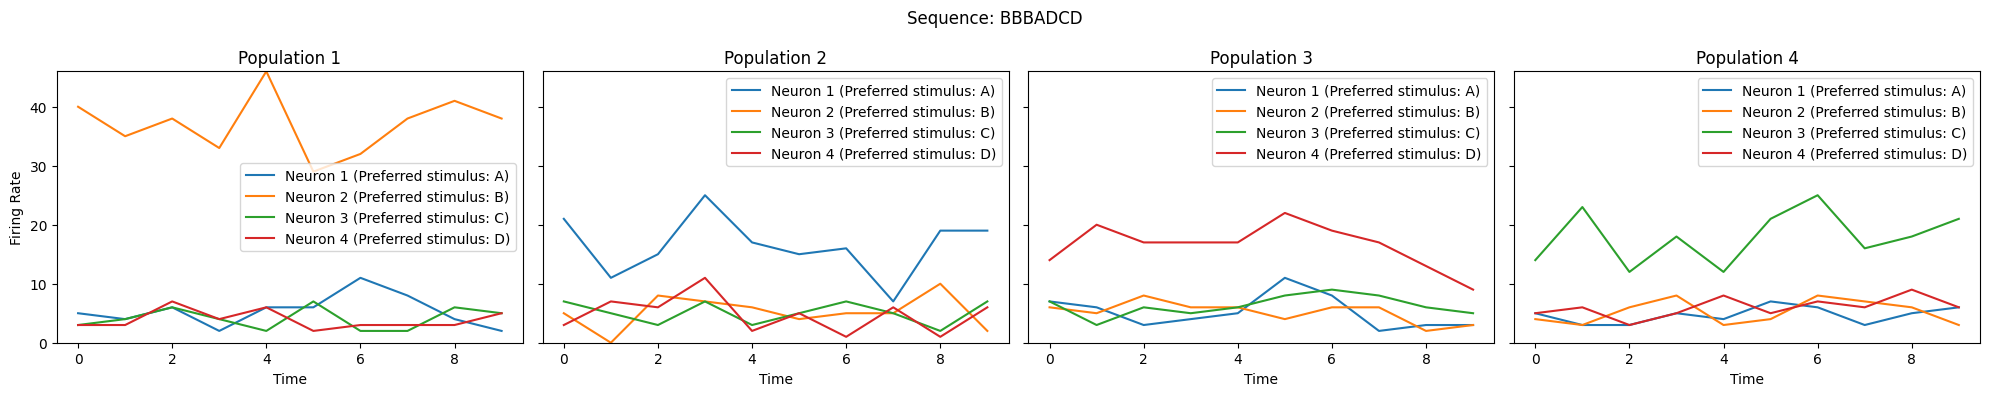

In [ ]:
#Slot model

import numpy as np
import matplotlib.pyplot as plt

# Simulation settings
total_time = 10  # total time in seconds
dt = 1  # finer time step for Poisson generation
time = np.arange(0, total_time, dt)
num_populations = 4  # four populations
neurons_per_pop = 4  # four neurons per population (A, B, C, D)
lambda_base = 5  # baseline firing rate (spikes/s)
lambda_active = 50  # maximum firing rate (spikes/s)
bin_size = 1  # bin size for smoothing
num_bins = int(total_time / bin_size)

# Activation mapping for each letter to neuron index
activation_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3}

def adjust_sequence_for_repeats(sequence):
    """ Handles repeated characters and their counts directly for compression """
    result = []
    i = 0
    while i < len(sequence):
        count = 1
        while i + 1 < len(sequence) and sequence[i + 1] == sequence[i]:
            count += 1
            i += 1
        if count > 1:
            result.append(sequence[i] + str(count))
        else:
            result.append(sequence[i])
        i += 1
    return result[:num_populations]  # Only use as many as there are populations

def sigmoid_firing_rate(count, lambda_base, lambda_active):
    """ Calculates firing rate based on repeat count using a sigmoid function """
    k = 1  # Steepness of the curve
    x0 = 2  # Midpoint of the sigmoid
    lambda_max = lambda_active - lambda_base
    rate_increase = lambda_max / (1 + np.exp(-k * (count - x0)))
    return lambda_base + rate_increase

# Input sequence and adjust for repeats
input_sequence = "BBBADCD"
adjusted_sequence = adjust_sequence_for_repeats(input_sequence)
#print("Adjusted Sequence:", adjusted_sequence)

# Initialize spike counts array for all populations
spike_counts = np.zeros((num_populations, neurons_per_pop, len(time)))

# Generate spikes for each neuron in each population
np.random.seed(42)
for pop_index, seq_item in enumerate(adjusted_sequence):
    char = seq_item[0]
    repeat_count = int(seq_item[1]) if len(seq_item) > 1 else 1
    neuron_index = activation_mapping[char]
    for t_index, t in enumerate(time):
        for neuron in range(neurons_per_pop):
            current_rate = (sigmoid_firing_rate(repeat_count, lambda_base, lambda_active)
                            if neuron == neuron_index else lambda_base)
            spike_counts[pop_index, neuron, t_index] = np.random.poisson(current_rate * dt)

# Aggregate spikes into bins and calculate firing rates for plotting
firing_rates = np.zeros((num_populations, neurons_per_pop, num_bins))
for pop_index in range(num_populations):
    for neuron_index in range(neurons_per_pop):
        for b in range(num_bins):
            start_index = b * int(bin_size / dt)
            end_index = start_index + int(bin_size / dt)
            firing_rates[pop_index, neuron_index, b] = np.sum(spike_counts[pop_index, neuron_index, start_index:end_index]) / bin_size

# Plotting
time_bins = np.arange(0, total_time, bin_size)
fig, axs = plt.subplots(1, num_populations, figsize=(20, 4), sharey=True)  # Changed to one row, four columns
max_firing_rate = np.max(firing_rates)  # Determine the maximum firing rate for uniform scaling
for i in range(num_populations):
    for j in range(neurons_per_pop):
        axs[i].plot(time_bins, firing_rates[i, j, :], label=f'Neuron {j+1} (Preferred stimulus: {chr(65+j)})')
    axs[i].set_title(f'Population {i+1}')
    axs[i].legend()
    axs[i].set_ylim(0, max_firing_rate)  # Uniform y-axis scale
    axs[i].set_xlabel('Time')
axs[0].set_ylabel('Firing Rate')
plt.suptitle(f'Sequence: {input_sequence}')
plt.tight_layout()
plt.show()

### Neural model -- short-term weight modification

In [ ]:
def one_hot_encode(sequence):
    if sequence == '':
        return np.zeros(1,4)

    # Mapping of characters to indices
    char_to_int = {'y': 0, 'r': 1, 'g': 2, 'b': 3}
    
    # Create an array of indices for each character in the sequence
    indices = np.array([char_to_int[char] for char in sequence])
    
    # Create the one-hot encoded array
    one_hot_encoded = np.zeros((len(sequence), len(char_to_int)), dtype=np.int32)
    one_hot_encoded[np.arange(len(sequence)), indices] = 1
    
    return one_hot_encoded

# Example usage
sequence = "rgby"
encoded_sequence = one_hot_encode(sequence)
print("Encoded Sequence:")
print(encoded_sequence)


def softmax(z, beta=1.0):
    # Shift by max to prevent overflow
    z_max = np.max(z)
    shifted_logits = z - z_max
    exp_shifted_logits = np.exp(shifted_logits / beta)
    softmax_output = exp_shifted_logits / np.sum(exp_shifted_logits)
    return softmax_output

Encoded Sequence:
[[0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]]


In [ ]:
# filters
def default(seq):
    return seq[-1]

def default3(seq):
    if seq.shape[0] < 3:
        return np.zeros_like(seq[-1])

    output = np.sum(seq[-3:], axis=0)
    return output

def repeat2(seq):
    if seq.shape[0] < 2:
        return np.zeros_like(seq[-1])

    output = np.sum(seq[-2:], axis=0)
    # Convert sums to 1 if they are 1, else to 0
    output = np.where(output == 2, 1, 0)
    return output

def repeat3(seq):
    if seq.shape[0] < 3:
        return np.zeros_like(seq[-1])

    output = np.sum(seq[-3:], axis=0)
    # Convert sums to 1 if they are 1, else to 0
    output = np.where(output == 2, 1, 0)
    return output

def repeat4(seq):
    if seq.shape[0] < 4:
        return np.zeros_like(seq[-1])

    output = np.sum(seq[-4:], axis=0)
    # Convert sums to 1 if they are 1, else to 0
    output = np.where(output == 2, 1, 0)
    return output



In [ ]:
def initialize_weights(num_features, num_classes):
    # random weights
    return np.random.normal(0, 1, size=(num_features, num_classes))

In [ ]:
def recurrent_model(seq, filters, weights=None, beta=1.0):
    num_classes = seq[-1].size

    # compute the context with pre-defined filters for the sequence
    context_vector = np.hstack([filter_func(seq) for filter_func in filters]+[seq.shape[0]])

    # context_vector is vector of length (num_features),
    # weights is a matrix of size (num_features, num_classes)
    output = context_vector @ weights

    # sample the choice and decide the output
    pred_dist = softmax(output, beta)
    choice = np.random.choice(np.arange(num_classes), p=pred_dist)
    return choice, pred_dist, context_vector

In [ ]:
def update_weights(weights, seq, context, pred, obs, alpha=0.01):
    new_pred = pred
    while np.argmax(new_pred) != np.argmax(obs):
        # weights is a matrix of size (num_features, num_classes)
        modified_weights = weights + alpha*np.outer(context, (pred - obs))
        new_pred = context @ modified_weights
        print(obs, new_pred, context, modified_weights)
        import pdb; pdb.set_trace()
    return modified_weights

In [ ]:
def simulate_trial(seq, filters):
    chars = 'yrgb'
    num_classes = len(chars)
    num_features = len(filters) * len(chars) + 1
    weights = initialize_weights(num_features, num_classes)

    for i in range(1, len(seq)):
        # define subsequence for trial
        subseq = seq[:i]
        print("target: ", subseq)
        
        # generate prediction
        subseq_onehot = one_hot_encode(subseq)
        _, pred, context = recurrent_model(subseq_onehot, filters, weights=weights, beta=1)

        # provide observation input
        obs = one_hot_encode(seq[i])[0]

        # update weights
        weights = update_weights(weights, seq, context, pred, obs)

        # generate output
        response = subseq[0]
        for j in range(i-1):
            choice, _, _ = recurrent_model(subseq_onehot, filters, weights=weights, beta=1)
            response += chars[choice]
        
        print("response: ", response)

In [ ]:
filters = [default, default3, repeat2]
test = 'rgbbyyrrrbrrb'
simulate_trial(test, filters)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3569eb68-a6a6-4122-9c3d-498e88f49235' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>